In [21]:
# Base packages
from torch.utils.data import Dataset
import torch
from torch.utils.data import DataLoader

# Defined packages
from inputs import RandomPattern, noise_input
from neuralBehaviors import *
from synapseBehaviors import *
from metrics import draw_weights

# PyMonnTorch and CoNeX
from pymonntorch import NeuronGroup, SynapseGroup, NeuronDimension, EventRecorder, Recorder

from conex import Neocortex, InputLayer, Synapsis, prioritize_behaviors, CorticalColumn
from conex.behaviors.synapses import SynapseInit, WeightInitializer, LateralDendriticInput, SimpleDendriticInput, WeightNormalization
from conex.behaviors.synapses.learning import SimpleSTDP
from conex.behaviors.neurons.axon import NeuronAxon
from conex.behaviors.neurons.specs import SpikeTrace, Fire, KWTA
from conex.behaviors.neurons.dendrite import SimpleDendriteStructure, SimpleDendriteComputation
from conex.behaviors.neurons.neuron_types.lif_neurons import LIF, ELIF
from conex.behaviors.network.time_resolution import TimeResolution



SIZE = 10
TIME = 30
NORM = 15
USE_LI = True
USE_KWTA = False
dataset = RandomPattern(
    pattern1=torch.tensor([1, 1, 0, 1, 1, 0, 0, 0, 0, 0]),
    pattern2=torch.tensor([0, 0, 0, 0, 0, 1, 1, 0, 1, 1]),
    period=10,
)


net = Neocortex(dt=0.1)

input_layer = NeuronGroup(size=SIZE, net=net, behavior={
    160: ResetIBehavior(),
    170: InputBehavior(dataset, isForceSpike=True),
    # 175: InputBehavior(noise_input, mean=0, std=0.01),
    # 260: LIFBehavior(func='base', R=10),
    # 340: FireBehavior(),
    360: SpikeTrace(tau_s=0.5),
    380: NeuronAxon(),
    500: EventRecorder(variables=['spikes']),
    
})


conex_out_behaviors = [
        SimpleDendriteStructure(), # 220
        SimpleDendriteComputation(), # 240
        SpikeTrace(tau_s=0.5), # 360
        NeuronAxon(), # 380
        
    ]
all_out_behs = {**prioritize_behaviors(conex_out_behaviors),
    260: LIFBehavior(func='base', R=100),
    340: FireBehavior(),
    341: Recorder(variables=['v']), # right after Fire
    500: EventRecorder(variables=['spikes']),
    }
if USE_KWTA:
    conex_out_behaviors.append(KWTA(k=1))
if USE_LI:
    all_out_behs[180] = LateralInhibition(alpha=150)

out_ng = NeuronGroup(net=net, size=2, tag='out', behavior=all_out_behs)
synapsis_input_out = SynapseGroup(net=net, src=input_layer, dst=out_ng, behavior={
                                    **prioritize_behaviors(
                                      [
                                        SynapseInit(), # 2
                                        WeightInitializer(mode='random', weight_shape=(10, 2), scale=1 + NORM // SIZE), # 3
                                        SimpleDendriticInput(), # 180
                                        SimpleSTDP(a_plus=10, a_minus=10), # 400
                                        WeightNormalization(norm=NORM), # 420
                                        
                                      ]),
                                      500: Recorder(variables=['weights']),}
                                    , tag="Proximal")



net.initialize(info=False)
oldW = synapsis_input_out.weights.clone()
net.simulate_iterations(500, measure_block_time=False)
newW = synapsis_input_out.weights.clone()

print(f"\nDiff W = \n{newW - oldW}")

print(f"input layer spikes: {input_layer['spikes'][0].shape[0]}")
print(f"out layer spikes: {out_ng['spikes'][0].shape[0] if out_ng['spikes'] else 0}")

print(f"Weights:\n{synapsis_input_out.weights}")




Diff W = 
tensor([[-3.7115,  4.6466],
        [-2.7658,  6.0157],
        [ 1.7778,  1.0627],
        [-4.1727,  2.4923],
        [-4.1647,  5.7974],
        [ 2.9827, -6.5119],
        [ 2.0794, -3.4909],
        [ 3.3034,  1.5167],
        [ 3.7363, -6.4275],
        [ 0.9351, -5.1012]])
input layer spikes: 2000
out layer spikes: 103
Weights:
tensor([[-3.0805,  6.7640],
        [-1.2198,  9.2903],
        [ 3.4977,  1.9609],
        [-3.9878,  2.7887],
        [-3.9721,  8.8875],
        [ 5.3965, -6.4558],
        [ 3.6193, -0.8813],
        [ 6.4993,  2.7986],
        [ 6.8793, -6.3002],
        [ 1.3680, -3.8528]])


Patterns:
	1: tensor([1, 1, 0, 1, 1, 0, 0, 0, 0, 0])
	2:tensor([0, 0, 0, 0, 0, 1, 1, 0, 1, 1])
tensor([[0.6311, 2.1174],
        [1.5460, 3.2746],
        [1.7199, 0.8982],
        [0.1849, 0.2964],
        [0.1926, 3.0901],
        [2.4138, 0.0561],
        [1.5399, 2.6095],
        [3.1959, 1.2819],
        [3.1429, 0.1274],
        [0.4329, 1.2484]])
tensor([15., 15.])
tensor([[-3.0805,  6.7640],
        [-1.2198,  9.2903],
        [ 3.4977,  1.9609],
        [-3.9878,  2.7887],
        [-3.9721,  8.8875],
        [ 5.3965, -6.4558],
        [ 3.6193, -0.8813],
        [ 6.4993,  2.7986],
        [ 6.8793, -6.3002],
        [ 1.3680, -3.8528]])
tensor([15.0000, 15.0000])


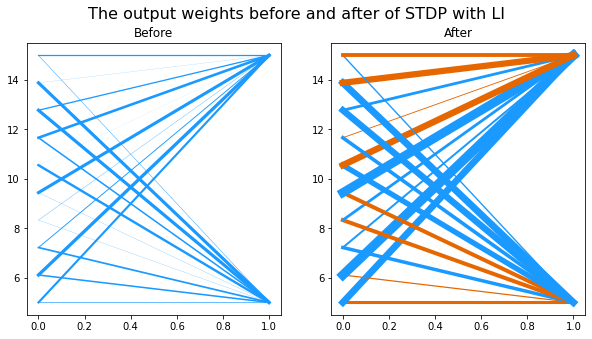

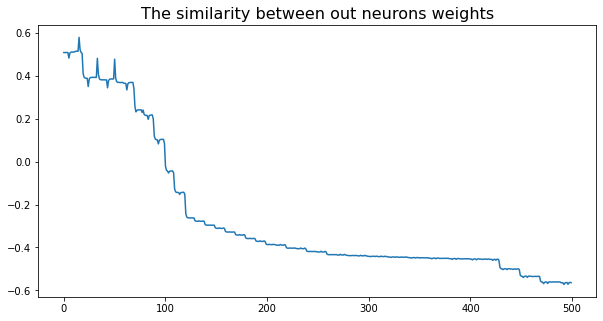

In [22]:
import matplotlib.pyplot as plt
print(f"Patterns:\n\t1: {dataset.pats[0]}\n\t2:{dataset.pats[1]}")

print(oldW)
print(oldW.sum(0))
print(newW)
print(newW.sum(0))
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
draw_weights(weights=oldW, ax=ax[0], scale_w=1)
draw_weights(weights=newW, ax=ax[1], scale_w=1)
title = "The output weights before and after of STDP"
if USE_KWTA:
    if USE_LI:
        title += " with LI & KWTA"
    else:
        title += " with KWTA"
elif USE_LI:
    title += " with LI"

plt.suptitle(title, fontsize=16)
ax[0].set_title("Before")
ax[1].set_title("After")
plt.show()

from torch.nn.functional import cosine_similarity
w_history = synapsis_input_out['weights'][0]
sim_history = []
for iter in range(w_history.shape[0]):
    sim_history.append(cosine_similarity(w_history[iter, :, 0], w_history[iter, :, 1], dim=0))
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(sim_history)
ax.set_title("The similarity between out neurons weights", fontsize=16)
plt.show()



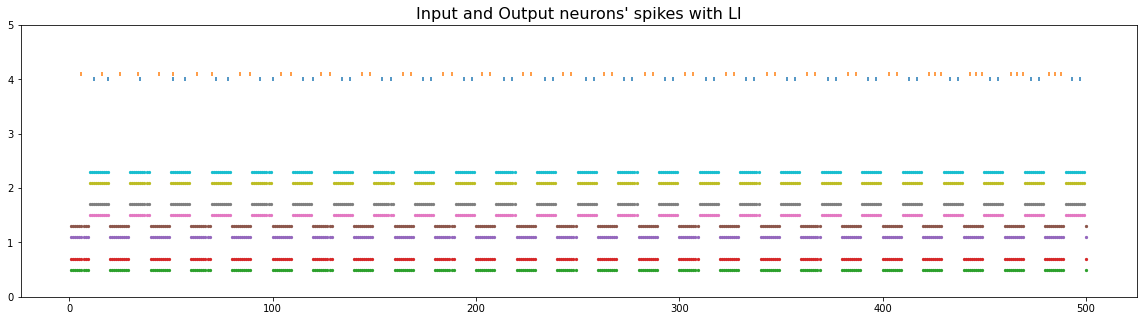

In [23]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(20, 5))


spikes = out_ng['spikes'][0]
zeros = out_ng['spikes'][0][:, 1] == 0
firsts = spikes[zeros]
seconds = spikes[~zeros]
ax.scatter(x=out_ng['spikes', 0][zeros][:, 0], y=4 * torch.ones(zeros.sum()), marker='|', s=20)
ax.scatter(x=out_ng['spikes', 0][~zeros][:, 0], y=4.1 * torch.ones((~zeros).sum()), marker='|', s=20)


spikes = input_layer['spikes'][0]
for i in input_layer['spikes'][0][:, 1].unique():
    times = input_layer['spikes'][0][:, 1] == i
    ax.scatter(x=spikes[times][:, 0], y=0.5 + 0.2 * i * torch.ones(times.sum()), marker='.', s=20)
    
ax.set_ylim(0, 5)
title = "Input and Output neurons' spikes"
if USE_KWTA:
    if USE_LI:
        title += " with LI & KWTA"
    else:
        title += " with KWTA"
elif USE_LI:
    title += " with LI"

ax.set_title(title, fontsize=16)
plt.show()

